## Random Forest Base

### Data Preparation

In [4]:
import matplotlib.pyplot as plt
import cmocean as cm
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

In [5]:
# Reading Data
dir_name="../../data/member_001"

chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2=read_xarray(dir_name)

mld=mld.isel(bnds=0)
sss=sss.isel(bnds=0)
sst=sst.isel(bnds=0)
xco2=xco2.isel(bnds=0)


mld['time'] =mld.time.indexes['time'].to_datetimeindex()
sss['time'] =sss.time.indexes['time'].to_datetimeindex()
sst['time'] =sst.time.indexes['time'].to_datetimeindex()
xco2['time'] =xco2.time.indexes['time'].to_datetimeindex()

/local/ipykernel_2436288/3409989473.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  mld['time'] =mld.time.indexes['time'].to_datetimeindex()
/local/ipykernel_2436288/3409989473.py:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sss['time'] =sss.time.indexes['time'].to_datetimeindex()
/local/ipykernel_2436288/3409989473.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length

In [6]:
xco2

<xarray.Dataset>
Dimensions:    (time: 421)
Coordinates:
    TLONG      float64 ...
    TLAT       float64 ...
  * time       (time) datetime64[ns] 1982-02-01 1982-03-01 ... 2017-02-01
Data variables:
    time_bnds  (time) object ...
    XCO2       (time) float32 ...
Attributes: (12/16)
    CDI:                       Climate Data Interface version 1.7.2 (http://m...
    history:                   Thu Apr 05 13:33:27 2018: cdo seltimestep,1/42...
    source:                    CCSM POP2, the CCSM Ocean Component
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    title:                     b.e11.B20TRC5CNBDRD.f09_g16.001
    contents:                  Diagnostic and Prognostic Variables
    ...                        ...
    nsteps_total:              750
    tavg_sum:                  2592000.0
    tavg_sum_qflux:            2592000.0
    nco_openmp_thread_number:  1
    NCO:                       4.6.9
    CDO:                       Climate Data Operators version 1.7.2 (http://m...

In [7]:

pco2['time'] = pco2.time.dt.strftime("%Y-%m")
chl['time'] = chl.time.dt.strftime("%Y-%m")
mld['time'] =mld.time.dt.strftime("%Y-%m")
sss['time'] =sss.time.dt.strftime("%Y-%m")
sst['time'] =sst.time.dt.strftime("%Y-%m")
xco2['time'] =xco2.time.dt.strftime("%Y-%m")

In [8]:
# Creating one singular df
data_read=xr.merge([chl.Chl,chl.Chl_socat,mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2,pco2.pCO2,pco2.pCO2_socat])

In [9]:
tmp_data=data_read.to_dataframe().reset_index()
tmp_data=tmp_data.drop(columns=['TLONG', 'TLAT', 'time_bnds'])

In [10]:
# tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
# tmp_data["Chl"]=chl_data["Chl"]
# tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
# tmp_data["pCO2"]=pco2_data["pCO2"]

In [11]:
check=tmp_data.set_index(["time","ylat","xlon"]).to_xarray()

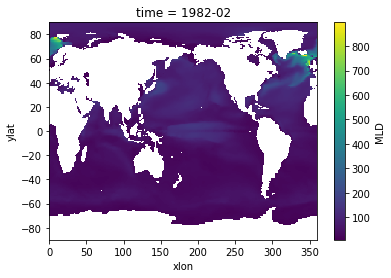

In [12]:
check.MLD[1].plot()

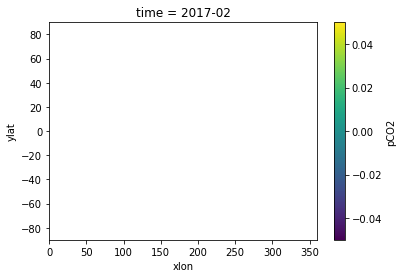

In [13]:
check.pCO2[421].plot()

In [14]:
tmp_data_final=tmp_data[tmp_data.time != "1982-01"]
tmp_data_final=tmp_data_final[tmp_data_final.time != "2017-02"]

In [15]:
features_socat = ['time','xlon', 'ylat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time','xlon', 'ylat','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data_final[features_socat]
combined=tmp_data_final[features]

In [16]:
# drop rows where pco2 or pco2_socat == NA or 0
combined_socat.dropna(subset = ["pCO2_socat"],inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]

combined.dropna(subset = ["pCO2"],inplace=True)
combined= combined[combined['pCO2']!=0]

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [17]:
combined.head()

,time,xlon,ylat,SST,SSS,Chl,XCO2,pCO2
64820,1982-02,0.5,-69.5,-1.552322,33.641834,0.064728,340.848541,259.943180
64821,1982-02,0.5,-68.5,-1.626047,33.667816,0.079743,340.848541,264.257161
64822,1982-02,0.5,-67.5,-1.607591,33.572289,0.077933,340.848541,269.302537
64823,1982-02,0.5,-66.5,-1.496069,33.424641,0.069886,340.848541,275.715089
64824,1982-02,0.5,-65.5,-1.207762,33.317802,0.060309,340.848541,285.947764


In [18]:
combined_socat.isna().sum()

time          0
xlon          0
ylat          0
SST_socat     0
SSS_socat     0
Chl_socat     0
XCO2          0
pCO2_socat    0
dtype: int64

In [19]:
#separating X and y
X_socat=combined_socat.iloc[:,1:-1]
X=combined.iloc[:,1:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']


In [20]:
combined.xlon.min(),combined.xlon.max(),combined.ylat.min(),combined.ylat.max()

(0.5, 359.5, -77.5, 89.5)

In [21]:
# Two Different Imputation Methods

# KNNImputer
# from sklearn.impute import KNNImputer
# imp = KNNImputer(n_neighbors=2)
# X=imp.fit_transform(X)
# X_socat=imp.fit_transform(X_socat)

# SimpleImputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

### Modeling - Random Forest: full




In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)

regressor=RandomForestRegressor(n_estimators=20, random_state=42, verbose=3,n_jobs=-1, 
                                max_depth=10,warm_start= True)
regressor.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20building tree 11 of 20

building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    1.6s remaining:    6.3s


building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    1.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.3s finished


RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, random_state=42,
                      verbose=3, warm_start=True)

In [23]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.6s remaining:    2.2s


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   4 out of  20 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.6s remaining:    2.5s


building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   4 out of  20 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=12)]: Done  11 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20
building tree 4 of 20

building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.8s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    1.0s remaining:    0.8s


Scores: [20.38981969 20.37132857 20.43572299]
Mean: 20.398957081643985
Standard deviation: 0.027071253594377603


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished


### Final Result: full

Socat RMSE: 

Whole Grid Rmse: 

In [24]:
# On Socat
y_pred=regressor.predict(X_socat)
test_mse=mean_squared_error(y_socat, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   4 out of  20 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished


20.153309276060092

In [25]:
## The whole grid
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred
final_test_rmse

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   4 out of  20 | elapsed:    0.9s remaining:    3.6s
[Parallel(n_jobs=12)]: Done  11 out of  20 | elapsed:    1.4s remaining:    1.2s
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    2.7s finished


31.367750555451675

### Modeling - Random Forest Full


Uses train_test_split build into sklearn.model_selection


By default this method shuffles the data (30% = testing 70%=training/validation)
- Will test validation via 7-fold cross validation

Train  = 70%, Test   = 30%

In [26]:

X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)


In [28]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

regressor=RandomForestRegressor(n_estimators=20, random_state=42)
regressor.fit(X_train, y_train)

forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=7)
forest_rmse_scores = np.sqrt(-forest_scores)

In [29]:
display_scores(forest_rmse_scores)

Scores: [9.2301628  9.02248863 9.01244979 8.87989834 9.18850927 9.23339696
 9.13921789]
Mean: 9.100874811730597
Standard deviation: 0.12318480298505859


In [27]:
#Fine Tuning Using RandomizedSearch

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=20, high=50),
        'max_features': randint(low=1, high=6),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=7, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

final_model =rnd_search.best_estimator_



In [28]:
final_model =rnd_search.best_estimator_


### Final Result

In [30]:
y_pred=regressor.predict(X_socat)
test_mse=mean_squared_error(y_socat, y_pred,squared=True)
np.sqrt(test_mse)

5.495177396522989

In [31]:
## The whole grid
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

### Visualization of the Residual

In [32]:
combined["residual"] = error

In [33]:
combined["pred"] = y_pred

In [34]:
combined_tmp=combined.set_index(["time","ylat","xlon"])
result_data=combined_tmp[["residual"]]
result_data = result_data.sort_index()


In [35]:
combined_tmp=combined.set_index(["time","ylat","xlon"])
pred_data=combined_tmp[["pred","pCO2"]]
pred_data = pred_data.sort_index()

In [36]:
ds = result_data.to_xarray()
ds_pred = pred_data.to_xarray()

(array([2.500000e+02, 1.705000e+03, 2.020000e+03, 2.102000e+03,
        4.475000e+03, 1.462500e+04, 5.726300e+04, 2.415970e+05,
        1.302069e+06, 7.729161e+06, 5.790585e+06, 1.214105e+06,
        4.082770e+05, 1.972660e+05, 1.363550e+05, 7.275500e+04,
        3.261000e+04, 1.450100e+04, 7.971000e+03, 5.436000e+03,
        4.240000e+03, 3.215000e+03, 2.333000e+03, 1.766000e+03,
        1.184000e+03, 7.820000e+02, 4.390000e+02, 2.270000e+02,
        7.200000e+01, 1.400000e+01]),
 array([-241.78236199, -217.33857802, -192.89479405, -168.45101008,
        -144.00722611, -119.56344214,  -95.11965816,  -70.67587419,
         -46.23209022,  -21.78830625,    2.65547772,   27.09926169,
          51.54304566,   75.98682963,  100.4306136 ,  124.87439758,
         149.31818155,  173.76196552,  198.20574949,  222.64953346,
         247.09331743,  271.5371014 ,  295.98088537,  320.42466934,
         344.86845331,  369.31223729,  393.75602126,  418.19980523,
         442.6435892 ,  467.08737317, 

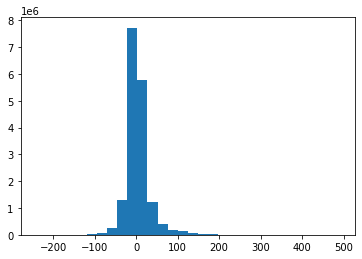

In [37]:
plt.hist(error,bins=30)

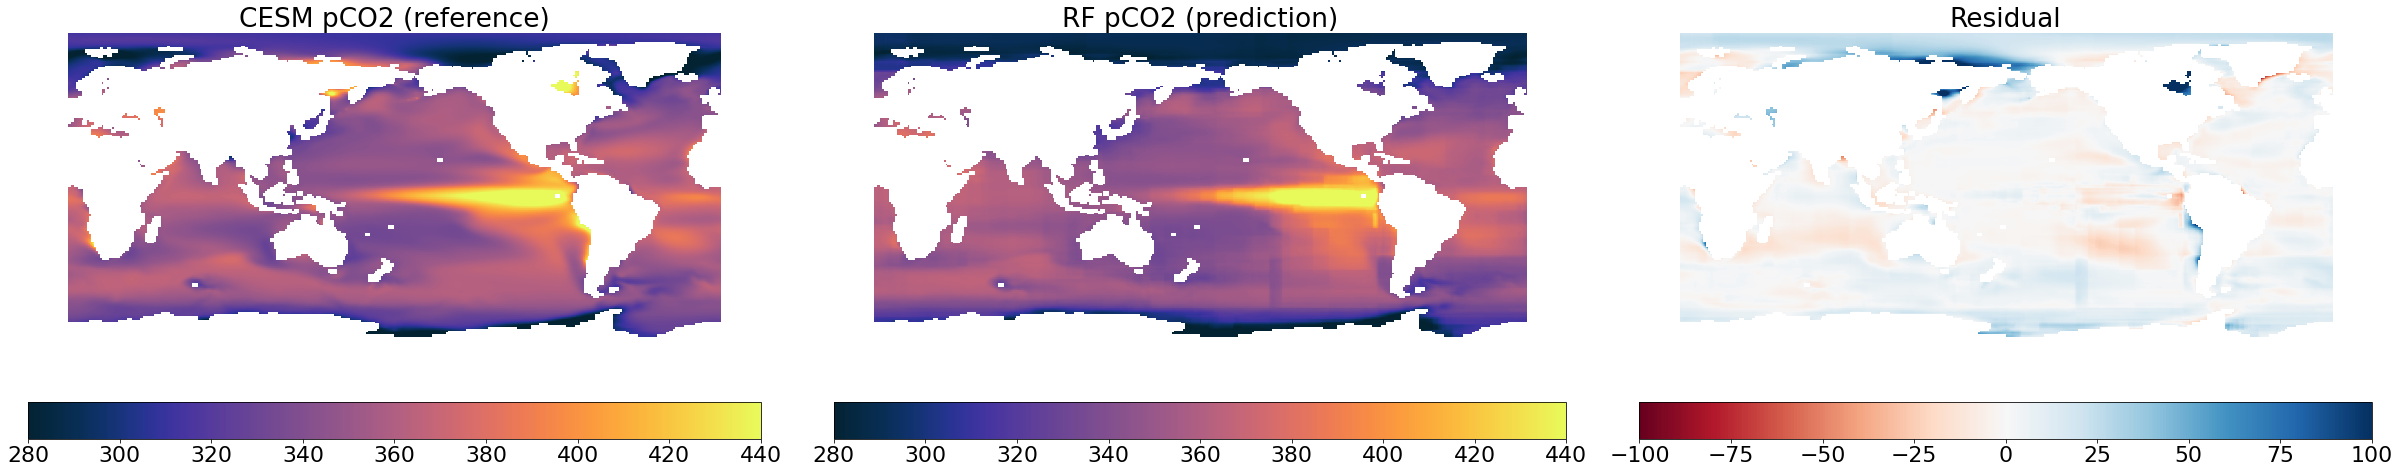

In [38]:
import matplotlib.colors as mcolors

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

im0 = axis[0].imshow(np.flipud(ds_pred.pCO2.mean('time').data),cmap = cm.cm.thermal,norm=norm)
cbar0 = figure.colorbar(im0, ax=axis[0], orientation='horizontal')
axis[0].set_title("CESM pCO2 (reference)")
axis[0].axis('off')

im1 = axis[1].imshow(np.flipud(ds_pred.pred.mean('time').data),cmap = cm.cm.thermal,norm=norm)
cbar1 = figure.colorbar(im1, ax=axis[1], orientation='horizontal')
axis[1].set_title("RF pCO2 (prediction)")
axis[1].axis('off')


norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im2 = axis[2].imshow(np.flipud(ds.residual.mean('time').data),cmap = "RdBu",norm=norm2)
cbar2 = figure.colorbar(im2, ax=axis[2], orientation='horizontal')
axis[2].set_title("Residual")
axis[2].axis('off')

plt.subplots_adjust(wspace=0.1)
# figure.suptitle("Average CESM RF pCO2 | Prediction | Residual - 1987/02-2017/01")
# plt.savefig("../../assets/figure2.2_rf_socat.jpg", dpi=200)

In [39]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.14.1


In [40]:
combined_tmp.reset_index(inplace=True)
avg_time=combined_tmp.groupby(by="time").mean()
avg_time_res = avg_time["residual"]


In [41]:
avg_time_res.index = pd.to_datetime(avg_time_res.index, format='%Y-%d')


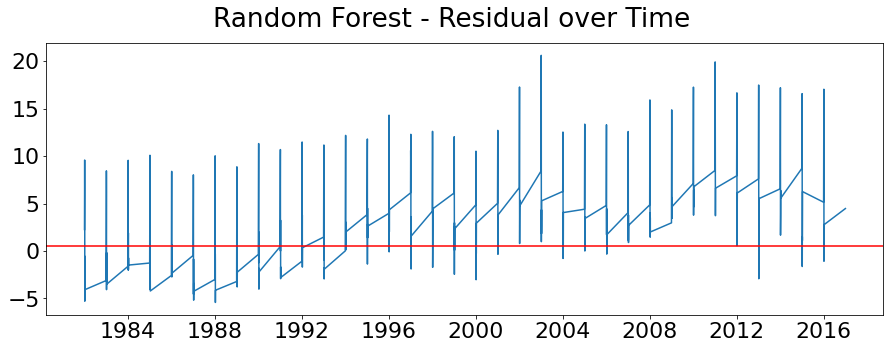

In [42]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(avg_time_res)
ax.xaxis_date()     # interpret the x-axis values as dates
ax.axhline(y = 0.5, color = 'r', linestyle = '-')

fig.suptitle("Random Forest - Residual over Time")
# plt.savefig("../../assets/figur7.1_rf_cesm_residual_over_all_time.jpg")
plt.show()


In [43]:
tmp1=avg_time_res[218:]
xlabels =[]
for i in range(len(tmp1.index)):
    if i%12==0:
        xlabels.append(tmp1.index[i].year)
    else:
        xlabels.append("")

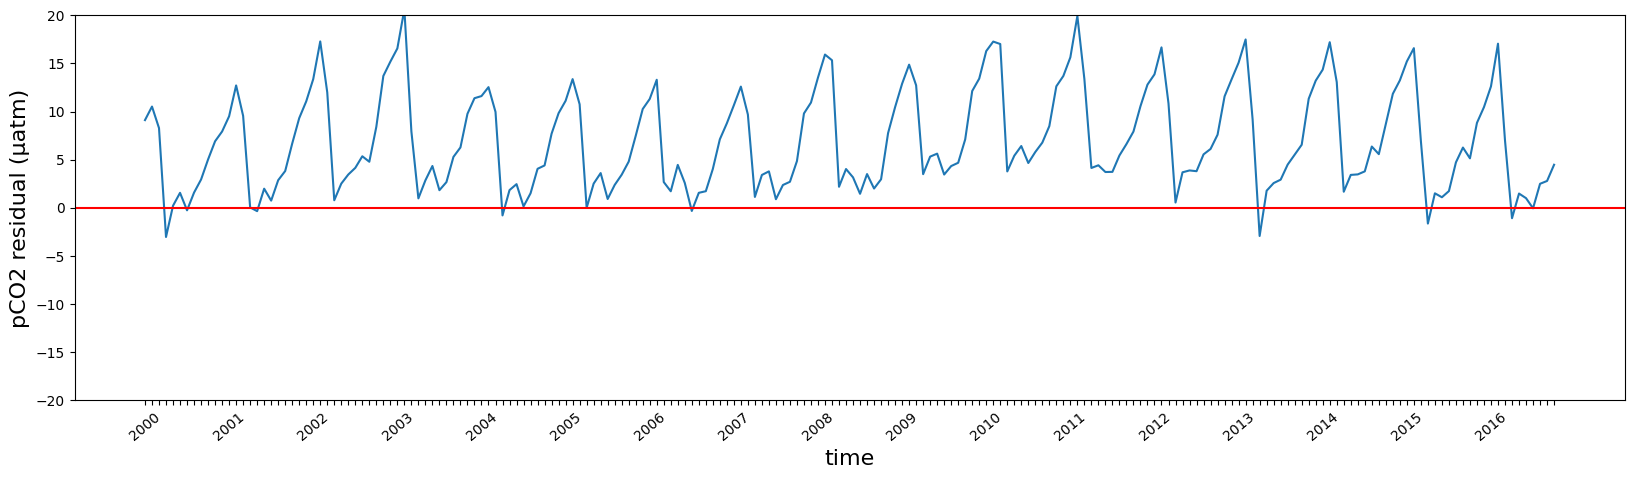

In [49]:
plt.rcdefaults()

# Residual over time
fig = pyplot.figure(figsize = (20,5))
plt.plot(list(avg_time_res[218:]))
plt.xticks(ticks=range((420-218)),labels = xlabels,rotation=40)
plt.ylim([-20, 20])
plt.axhline(y = 0.0, color = 'r', linestyle = '-')
plt.xlabel('time', size=16)
plt.ylabel('pCO2 residual (μatm)', size=16)
# fig.suptitle("Random Forest - Residual over Time")
# plt.savefig("../../assets/figur7.1_rf_cesm_residual_over_after 2000.jpg", bbox_inches='tight', dpi=200)
plt.show();

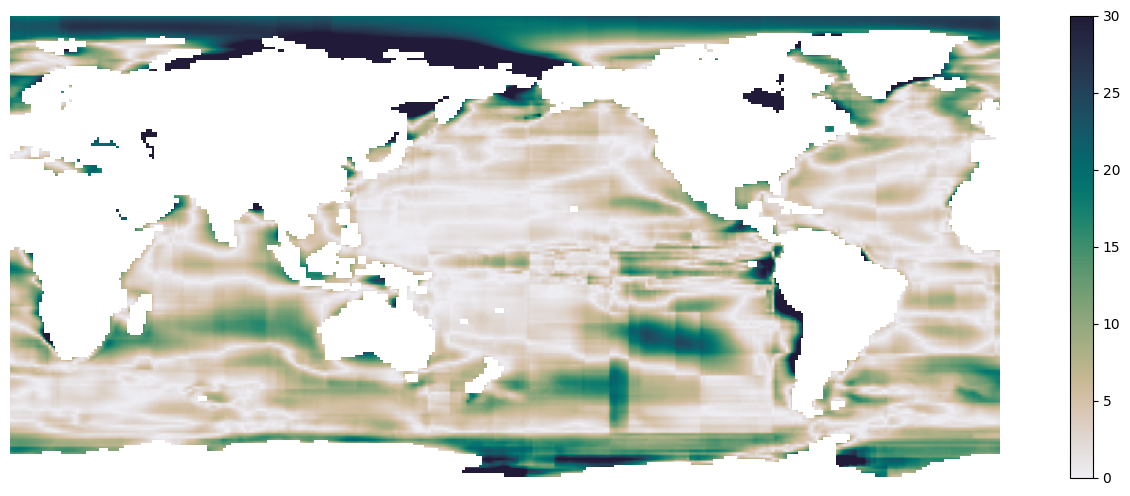

In [51]:
# Residual over space
avg_space=combined_tmp.drop('time', axis=1).groupby(by=["ylat", "xlon"]).mean().reset_index()
avg_space_res = np.absolute(avg_space.pivot(index='ylat', columns='xlon', values='residual').values)

figure, axis = plt.subplots(1, figsize=(18,6))
# norm = mcolors.Normalize(vmin=280, vmax = 440)
im0 = axis.imshow(np.flipud(avg_space_res),cmap = cm.cm.rain,label="Residual", vmin=0, vmax=30)
cbar0 = figure.colorbar(im0, ax=axis)
axis.axis('off')

plt.subplots_adjust(wspace=0.1)
# plt.savefig("../../assets/figur7.1_rf_cesm_residual_over_after 2000_space.jpg", bbox_inches='tight', dpi=200)

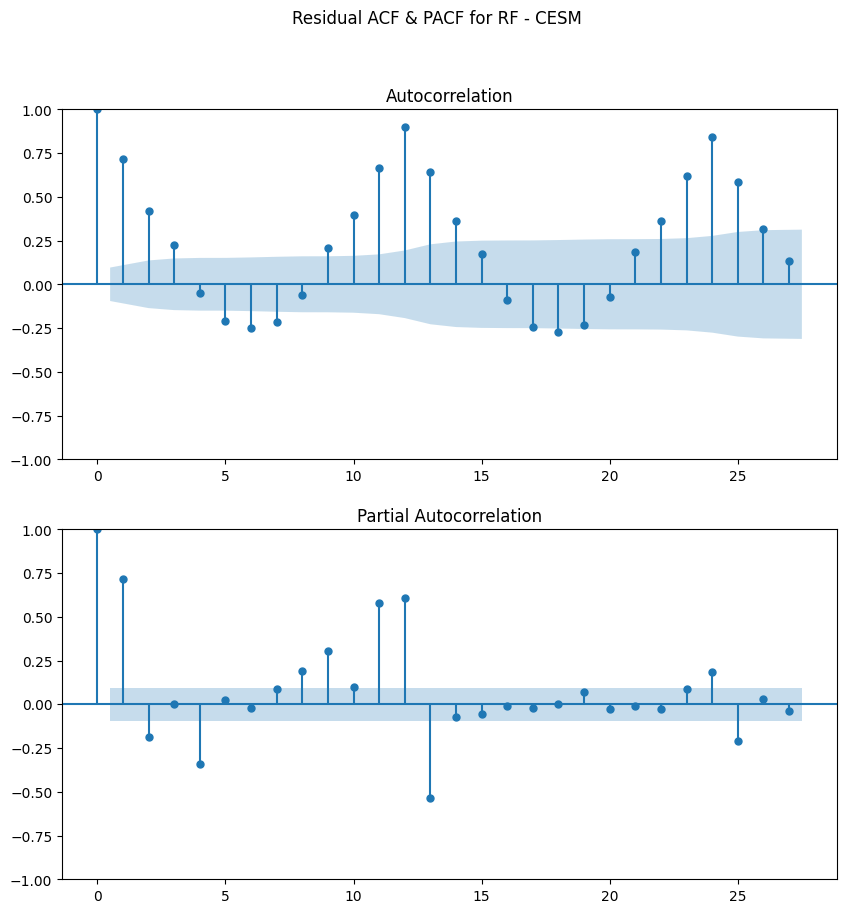

In [52]:
fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res, ax=pyplot.gca())

fig.suptitle("Residual ACF & PACF for RF - CESM")
plt.show();

# plt.savefig("../../assets/figur6.1_rf_cesm_acf_socat.jpg")

In [53]:
# Compute and predict anomaly
regressor=RandomForestRegressor(n_estimators=20, random_state=42)
regressor.fit(X_train, y_train - y_train.mean())

anomaly_pred = regressor.predict(X)
combined_tmp['pred_anomaly'] = anomaly_pred
combined_tmp['pCO2_anomaly'] = combined_tmp['pCO2'] - combined_tmp['pCO2'].mean()

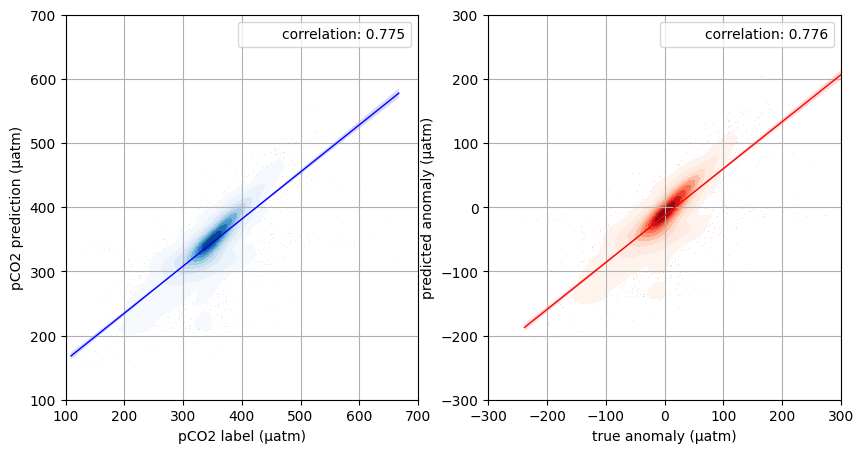

In [56]:
# Scatter plot
sample_data = combined_tmp.sample(n=10000)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

# Define limits for the plots
limits_1 = [100, 700]
limits_2 = [-300, 300]

# First: pred vs truth
correlation = np.corrcoef(sample_data[['pCO2']].values.squeeze(), sample_data[['pred']].values.squeeze())[0, 1]

sns.scatterplot(data=sample_data, x='pCO2', y='pred', s=0.1, ax=ax[0])
sns.kdeplot(data=sample_data, x='pCO2', y='pred', fill=True, cmap='Blues', ax=ax[0], label=f'correlation: {correlation:.3f}')
sns.regplot(data=sample_data, x='pCO2', y='pred', scatter=False, ax=ax[0], color='blue', line_kws={"linewidth": 1})
ax[0].set_xlabel('pCO2 label (μatm)')
ax[0].set_ylabel('pCO2 prediction (μatm)')
ax[0].set_xlim(limits_1)
ax[0].set_ylim(limits_1)
ax[0].legend()
ax[0].grid(True)

# Second: residual vs truth
correlation = np.corrcoef(sample_data[['pCO2_anomaly']].values.squeeze(), sample_data[['pred_anomaly']].values.squeeze())[0, 1]

sns.scatterplot(data=sample_data, x='pCO2_anomaly', y='pred_anomaly', color='red', s=0.1, ax=ax[1])
sns.kdeplot(data=sample_data, x='pCO2_anomaly', y='pred_anomaly', fill=True, cmap='Reds', ax=ax[1], label=f'correlation: {correlation:.3f}')
sns.regplot(data=sample_data, x='pCO2_anomaly', y='pred_anomaly', scatter=False, ax=ax[1], color='red', line_kws={"linewidth": 1})
ax[1].set_xlabel('true anomaly (μatm)')
ax[1].set_ylabel('predicted anomaly (μatm)')
ax[1].set_xlim(limits_2)
ax[1].set_ylim(limits_2)
ax[1].legend()
ax[1].grid(True)

# plt.savefig("../../assets/figur7.1_rf_cesm_residual_over_after 2000_scatter.jpg", bbox_inches='tight', dpi=200)
plt.show();